## Project

The idea of this project is to analyze a synthetic sleep healt dataset using different unsupervised machine learning methods. 


In [18]:
# Necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from pandas.plotting import parallel_coordinates
import matplotlib.colors as mcolors
import seaborn as sns

Let's take a look of the dataset.

In [3]:
# dataset
data = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
print("First rows of the data:")
print(data.head())
print("\nColumns' Data Types:")
print(data.dtypes)
distinct_sleepdisorder = data['Sleep Disorder'].unique()
print(distinct_sleepdisorder)
distinct_BMICat = data['BMI Category'].unique()
print(distinct_BMICat)
distinct_occupation = data['Occupation'].unique()
print(distinct_occupation)


First rows of the data:
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60             8       Normal   
3                 4                       30             8        Obese   
4                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         126/83          77         4200            NaN  
1         

So, the dataset contains some columns which are not suitable for PCA or Kmeans such as Occupation, Gender, BMI Category, Blood Pressure and Sleep Disorder since they are not numerical. I will separate Blood Pressure for two different rows: systolic and diastolic. Thus, they can be used as a regular numeric variable. Also BMI Category needs a little bit of cleaning by combining Normal and Normal Weight values since they mean the same. The last step is to one-hot encode the categorical variables. Even though it increases the complexity of the model, it offers a nice way to compare PCA and Kmeans.

Next I define a few classed for a better structured code.

In [58]:
# Class lass for data preprocessing
class DataPreprocess: 
    def __init__(self, data):
        self.data = data
    
    def clean_onehot(self):
        self.data['BMI Category'] = self.data['BMI Category'].replace('Normal Weight', 'Normal')      # Unite Normal Weight and Normal as Normal
        if 'Blood Pressure' in self.data.columns:                                                # Separate Blood Pressure column to two different columns for numerical representation
            BP_split = self.data['Blood Pressure'].str.split('/', expand = True)  
            BP_split.columns = ['Systolic', 'Diastolic']
            # Change the datatypes to numeric
            BP_split['Systolic'] = pd.to_numeric(BP_split['Systolic'], errors = 'coerce')  
            BP_split['Diastolic'] = pd.to_numeric(BP_split['Diastolic'], errors = 'coerce')
            # Drop the original Blood Pressure column and add the new Splitted dataframe
            self.data = self.data.drop('Blood Pressure', axis = 1)
            self.data = pd.concat([self.data, BP_split], axis = 1)
        self.data = self.data.drop('Person ID', axis = 1)             # Not necessary for clustering

        # Perform One-Hot Encoding
        self.data = pd.get_dummies(self.data, columns=['BMI Category', 'Gender', 'Occupation', 'Sleep Disorder'])
        return self.data
    
    
    def scale_data(self):
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.data)
        return scaled_data

# Class for PCA

class PCAAnalyze:
    def __init__(self, data):
        self.data = data

    # For executing PCA
    def run_pca(self):                            
        pca = PCA()
        pca_comp = pca.fit_transform(self.data)
        explained_var = pca.explained_variance_ratio_
        return pca_comp, explained_var
    
    # For vizualisation
    def plot_scree(self, explained_var, scaled = False):
        cumulative_var = np.cumsum(explained_var)  # Calculate the cumulative sum
        plt.figure()
        plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        if scaled:
            plt.title('PCA Scree Plot, Scaled Data')
        else:
            plt.title('PCA Scree Plot, Unscaled Data')
        plt.grid(True)
        plt.show()

# Class for cluster analysis

class ClusterAnalyzer:
    def __init__(self, data):
        self.data = data
        
    def optimal_clusters(self, min_clusters = 2, max_clusters = 6, plot_elbow = False, plot_silhouette = False, scaled = False):  # Default case
        best_sil_score = -1
        best_n = min_clusters                                        # Default since less is more
        inertias = []
        sil_scores = []
        for n in range(min_clusters, max_clusters+1):
            kmeans = KMeans(n_clusters = n, random_state = 2025)
            labels = kmeans.fit_predict(self.data)
            score = silhouette_score(self.data, labels)
            inertia = kmeans.inertia_
            inertias.append(inertia)
            sil_scores.append(score)

            print(f"Clusters: {n}, Silhouette Score: {score: .3f}")
            if score > best_sil_score:
                best_sil_score = score
                best_n = n

        print("The optimal amount of clusters:", best_n)

        # Elbow plot
        if plot_elbow:
            plt.figure(figsize=(8,5))
            plt.plot(range(min_clusters, max_clusters+1), inertias, marker='o')
            plt.xlabel('The Number of Clusters')
            plt.ylabel('Inertia (SSE)')
            if scaled:
                plt.title('K-Means Elbow Method, Scaled Data')
            else:
                plt.title('K_Means Elbow Method, Unscaled Data')
            plt.grid(True)
            plt.show()
        
        # Silhouette plot
        if plot_silhouette:
            plt.figure(figsize=(8,5))
            plt.plot(range(min_clusters, max_clusters+1), sil_scores, marker='o', color='orange')
            plt.xlabel('The Number of Clusters')
            plt.ylabel('Silhouette Score')
            if scaled:
                plt.title('K-Means Silhouette Score vs. The Number of Clusters, Scaled Data')
            else:
                plt.title('K-Means Silhoutte Score Vs. The Number of Clusters, Unscaled Data')
            plt.grid(True)
            plt.show()
        return best_n
    
    # This DBSCAN function calculates the silhouette scores and SSEs for the defined range of epsilon. Also the distance metric can be defined
    # But the default is euclidean. 
    def run_dbscan(self, min_eps = 0.3, max_eps = 0.9, step= 0.02, min_samples = 5, metric = "euclidean", scaled = False):
        # Make sure that the data is Numpy Array-format
        data_np = np.array(self.data)
        eps_values = np.arange(min_eps, max_eps + step, step)
        sil_scores = []
        inertias = []

        #Loop DBSCAN for all the epsilons and save the silhouette scores and inertias as the performance metric
        for eps in eps_values:
            db = DBSCAN(eps=eps, min_samples=min_samples, metric = metric)
            labels = db.fit_predict(data_np)

            # Exclude noise from the calculation.
            unique_labels = set(labels)
            unique_labels.discard(-1)
            n_clusters = len(unique_labels)

            # Calculate the silhouette score
            score = silhouette_score(data_np, labels)
            sil_scores.append(score)

            # Then calculate SSE manually
            inertia = 0.0
            for label in unique_labels: 
                cluster_pts = data_np[labels == label]
                centroid = cluster_pts.mean(axis = 0)
                inertia += np.sum((cluster_pts - centroid) **2)
            inertias.append(inertia)
            print(f"eps: {eps:.3f}, Clusters: {n_clusters}, Silhouette: {score}, Inertia: {inertia}")

        # Plot inertia
        plt.figure(figsize=(8,5))
        plt.plot(eps_values, inertias, marker = 'o', color = 'orange')
        plt.xlabel('Epsilon')
        plt.ylabel('Inertia (SSE)')
        if scaled:
            plt.title('DBSCAN Inertia Vs. Epsilon, Scaled Data')
        else:
            plt.title('DBSCAN Inertia Vs. Epsilon, Unscaled Data')
        plt.grid(True)
        plt.show()

        # Plot silhoutte score
        plt.figure(figsize=(8,5))
        plt.plot(eps_values, sil_scores, marker='o', color='orange')
        plt.xlabel('Epsilon')
        plt.ylabel('Silhouette Score')
        if scaled:
            plt.title('DBSCAN Silhouette Score vs. Epsilon, Scaled Data')
        else: 
            plt.title('DBSCAN Silhouette Score vs. Epsilon, Unscaled Data')
        plt.grid(True)
        plt.show()

        return eps_values, inertias, sil_scores

### K-Means

Next I shall execute the K-Means clustering with both scaled and unscaled data.

Clusters: 2, Silhouette Score:  0.256
Clusters: 3, Silhouette Score:  0.336
Clusters: 4, Silhouette Score:  0.318
Clusters: 5, Silhouette Score:  0.363
Clusters: 6, Silhouette Score:  0.412
Clusters: 7, Silhouette Score:  0.464
Clusters: 8, Silhouette Score:  0.521
Clusters: 9, Silhouette Score:  0.560
Clusters: 10, Silhouette Score:  0.596
Clusters: 11, Silhouette Score:  0.621
Clusters: 12, Silhouette Score:  0.628
Clusters: 13, Silhouette Score:  0.663
Clusters: 14, Silhouette Score:  0.672
Clusters: 15, Silhouette Score:  0.688
Clusters: 16, Silhouette Score:  0.705
Clusters: 17, Silhouette Score:  0.708
Clusters: 18, Silhouette Score:  0.715
Clusters: 19, Silhouette Score:  0.731
Clusters: 20, Silhouette Score:  0.755
Clusters: 21, Silhouette Score:  0.727
Clusters: 22, Silhouette Score:  0.753
Clusters: 23, Silhouette Score:  0.752
Clusters: 24, Silhouette Score:  0.756
Clusters: 25, Silhouette Score:  0.766
Clusters: 26, Silhouette Score:  0.767
The optimal amount of clusters: 2

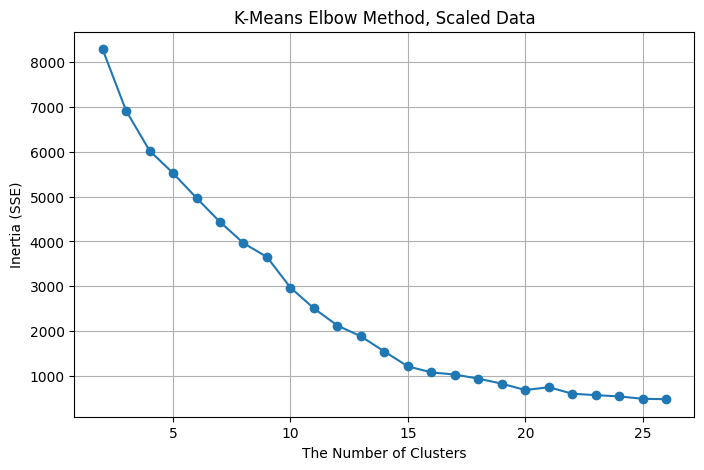

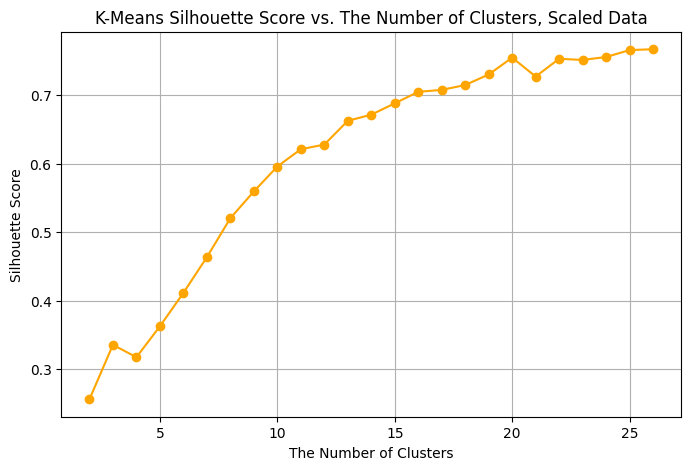

Clusters: 2, Silhouette Score:  0.646
Clusters: 3, Silhouette Score:  0.720
Clusters: 4, Silhouette Score:  0.739
Clusters: 5, Silhouette Score:  0.875
Clusters: 6, Silhouette Score:  0.926
Clusters: 7, Silhouette Score:  0.896
Clusters: 8, Silhouette Score:  0.932
Clusters: 9, Silhouette Score:  0.939
Clusters: 10, Silhouette Score:  0.934
Clusters: 11, Silhouette Score:  0.937
Clusters: 12, Silhouette Score:  0.932
Clusters: 13, Silhouette Score:  0.931
Clusters: 14, Silhouette Score:  0.933
Clusters: 15, Silhouette Score:  0.942
The optimal amount of clusters: 15


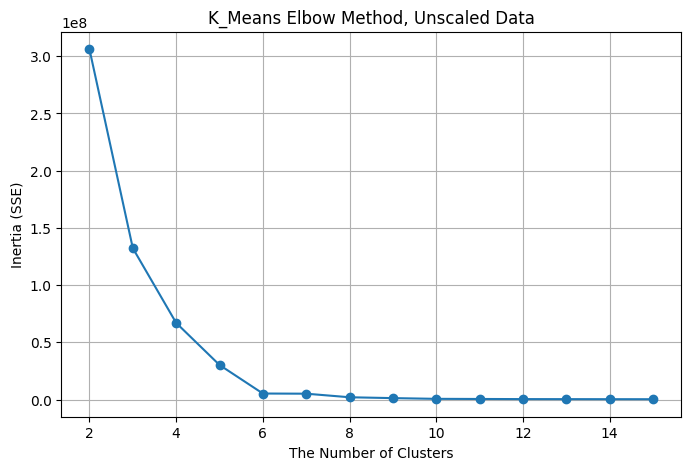

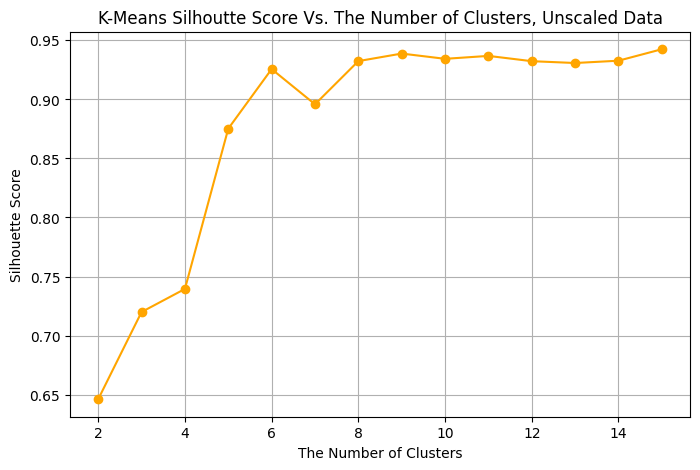

In [59]:
if __name__ == "__main__":

    # Start by preprocessing the data
    
    preprocessor = DataPreprocess(data)
    cleaned_data = preprocessor.clean_onehot()

    # Define scaled data separately
    scaled_data = preprocessor.scale_data()

    # Perform clustering. Since the amount of variables is high let's set min_clusters to 2 and max_clusters to 26
    scaled_cluster = ClusterAnalyzer(scaled_data)
    scaled_optimal_n = scaled_cluster.optimal_clusters(min_clusters=2, max_clusters= 26, plot_elbow=True, plot_silhouette= True, scaled=True)

    # Then for unscaled data
    unscaled_cluster = ClusterAnalyzer(cleaned_data)
    unscaled_optimal_n = unscaled_cluster.optimal_clusters(min_clusters=2, max_clusters=15, plot_elbow=True, plot_silhouette= True)
    

### Analysis of Scaled vs. Unscaled Data in K-Means Clustering

As shown in the elbow and silhouette plots, the results vary significantly depending on whether the data is scaled. K-Means relies on distance calculations between data points and cluster centroids, which makes it very sensitive to variables on different scales. For example, if one variable measures average salary (ranging in tens of thousands) and another measures fertility rate (typically between 1.5 and 6), the large salary range will dominate the distance calculations in an unscaled dataset. As a result, the number of clusters identified may be smaller because one or two high-range variables overshadow the others when calculating SSE (inertia).

On the other hand, when the data is scaled, each variable is brought to a comparable range, so all features contribute more equally to the distance calculations. This can reveal more subtle distinctions in the data, often resulting in a larger number of “optimal” clusters based on metrics such as silhouette score or inertia. Hence, these results emphasize the importance of careful data preprocessing, particularly scaling, when using distance-based methods like K-Means.

### DBSCAN  

Since K-Means only calculates circular areas or distances, the results can vary depending on the shape of the dataset. To address this problem, one can use DBSCAN which can form different shape of clusters. 

eps: 0.100, Clusters: 4, Silhouette: -0.49897323376184693, Inertia: 0.12514423076923104
eps: 0.110, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.120, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.130, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.140, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.150, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.160, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.170, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.180, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.190, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.200, Clusters: 7, Silhouette: -0.4205655718844785, Inertia: 0.34069570135746485
eps: 0.210, Clusters: 7, Silhouette: -0.42

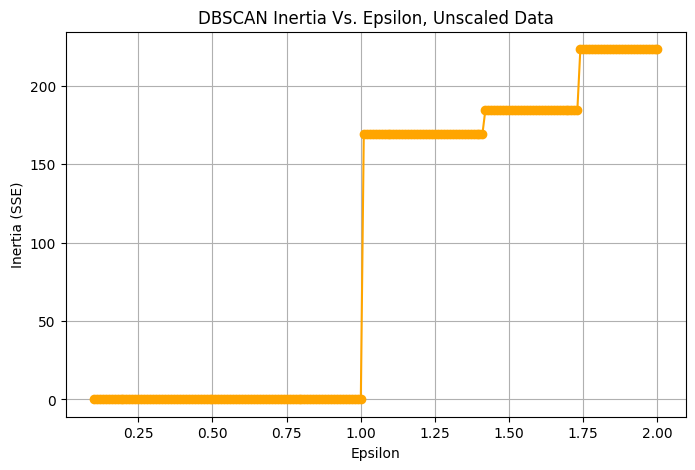

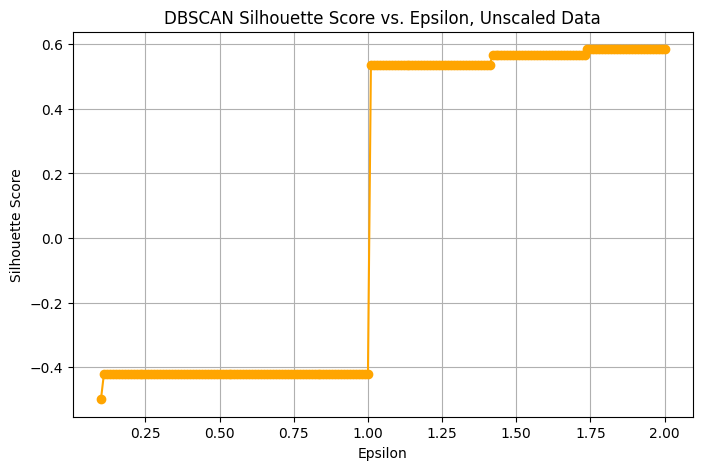

eps: 0.100, Clusters: 1, Silhouette: 0.006207752283170801, Inertia: 4.382742477944813e-30
eps: 0.110, Clusters: 1, Silhouette: 0.006207752283170801, Inertia: 4.382742477944813e-30
eps: 0.120, Clusters: 5, Silhouette: -0.1366874990395572, Inertia: 0.3648594605160644
eps: 0.130, Clusters: 9, Silhouette: 0.2980339825442747, Inertia: 2.3304593510940803
eps: 0.140, Clusters: 9, Silhouette: 0.2980339825442747, Inertia: 2.3304593510940803
eps: 0.150, Clusters: 9, Silhouette: 0.2980339825442747, Inertia: 2.3304593510940803
eps: 0.160, Clusters: 9, Silhouette: 0.2980339825442747, Inertia: 2.3304593510940803
eps: 0.170, Clusters: 9, Silhouette: 0.2980339825442747, Inertia: 2.3304593510940803
eps: 0.180, Clusters: 11, Silhouette: 0.5635576973659023, Inertia: 4.3065189569759985
eps: 0.190, Clusters: 11, Silhouette: 0.5635576973659023, Inertia: 4.3065189569759985
eps: 0.200, Clusters: 11, Silhouette: 0.5635576973659023, Inertia: 4.3065189569759985
eps: 0.210, Clusters: 11, Silhouette: 0.56355769736

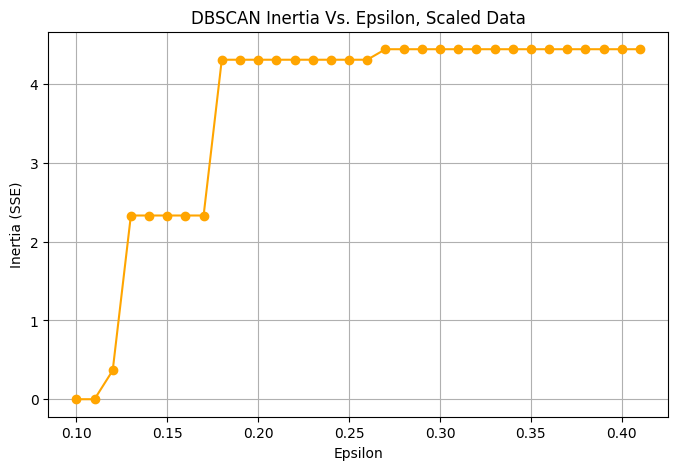

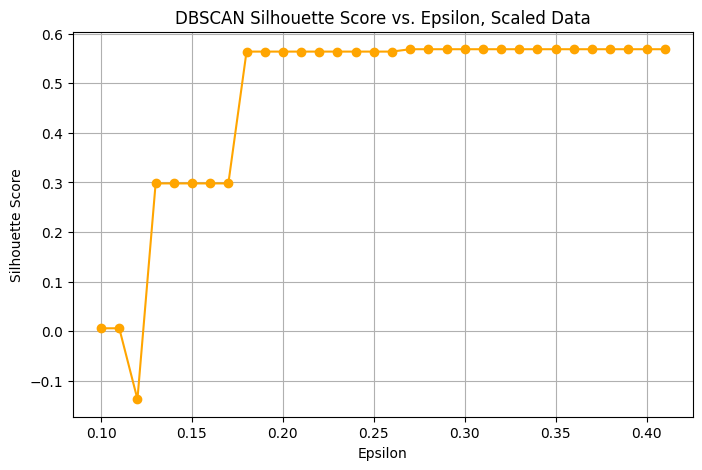

In [62]:
# We can use the previously scaled data but this time call the pre-defined run_dbscan function
if __name__ == "__main__":
    unscaled_cluster_analyzer = ClusterAnalyzer(cleaned_data)
    scaled_cluster_analyzer = ClusterAnalyzer(scaled_data)
    unscaled_eps_values, unscaled_inertias, unscaled_sil_scores = unscaled_cluster_analyzer.run_dbscan(min_eps=0.1, max_eps=2.0, step=0.01, min_samples=13, metric="euclidean", scaled = False)
    scaled_eps_values, scaled_inertias, sil_scores = scaled_cluster_analyzer.run_dbscan(min_eps=0.1, max_eps=0.4, step=0.01, min_samples=13, metric="euclidean", scaled = True)


### Analysis on DBSCAN

As observed with K-Means, unscaled data also produces unstable results with DBSCAN. When using a lower epsilon, the number of clusters drops dramatically compared to higher epsilon values. This is likely due to longer distances in unscaled data, which causes more observations to be classified as outliers because their distance to the nearest core point exceeds epsilon. The sudden "jumps" in performance metrics further highlight the model's instability on unscaled data.

In contrast, scaled data yields more consistent DBSCAN results. By plotting the performance metrics across a range of epsilon values and experimenting with different min_samples settings, I found that an epsilon of approximately 0.15 is a good compromise of the both performance criteria across various min_samples. Additionally, the min_samples parameter did not significantly affect the results, so I settled on a value of 13, which resulted in 9 clusters.

### PCA

I will execute similar code with PCA to help reduce dimension buy also detect influential clusters.



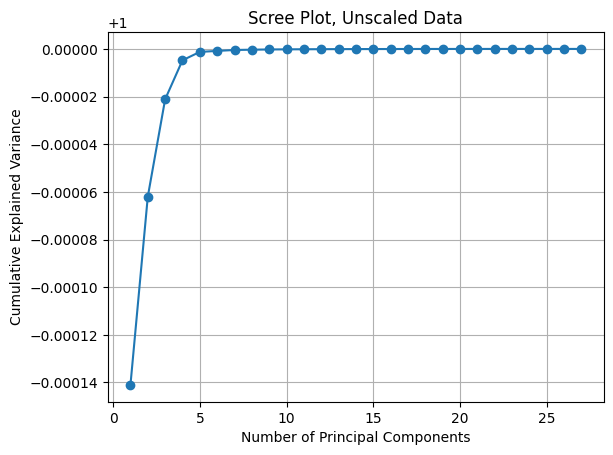

Amount of PCs explaining >80% of the variance with unscaled data: 1
A list of the portion variance explained with unscaled data: [9.99858979e-01 7.89982998e-05 4.08722570e-05 1.63758501e-05
 3.52170944e-06 4.18723723e-07 3.80378938e-07 1.29013141e-07
 9.84122303e-08 5.02491342e-08 3.79892965e-08 3.04266943e-08
 2.42229173e-08 1.94093437e-08 1.50308325e-08 1.26391632e-08
 1.12190977e-08 7.17687716e-09 5.76520380e-09 4.02733598e-09
 3.57680292e-09 2.04669457e-09 1.36427426e-09 8.76099364e-10
 7.68935579e-22 2.69335358e-22 5.79042595e-23]


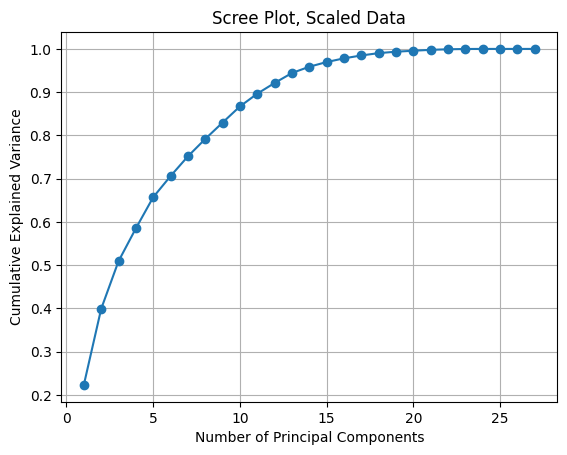

Amount of PCs explaining >80% of the variance with scaled data:  9


In [7]:
# Dataset
# We can use the same cleaned_data and scaled_data that we used with K-Means

# PCA

unscaled_pca_analyzer = PCAAnalyze(cleaned_data)
unscaled_pca_comp, unscaled_explained_var = unscaled_pca_analyzer.run_pca()

# Plot the explained variance
unscaled_pca_analyzer.plot_scree(unscaled_explained_var)

cumulative_variance_unscaled = np.cumsum(unscaled_explained_var)
n_components_unscaled = np.argmax(cumulative_variance_unscaled >= 0.8) + 1
print("Amount of PCs explaining >80% of the variance with unscaled data:", n_components_unscaled)
print("A list of the portion variance explained with unscaled data:", unscaled_explained_var)
# Then for scaled data
scaled_pca_analyzer = PCAAnalyze(scaled_data)
scaled_pca_comp, scaled_explained_variance = scaled_pca_analyzer.run_pca()
scaled_pca_analyzer.plot_scree(scaled_explained_variance, scaled= True)
cumulative_variance_scaled = np.cumsum(scaled_explained_variance)
n_components_scaled = np.argmax(cumulative_variance_scaled >= 0.8)+1
print("Amount of PCs explaining >80% of the variance with scaled data: ",  n_components_scaled)

### Analysis on PCA

PCA with unscaled data generates an odd screeplot. This is since only one PC explains almost all the variance. This can be seen from the list printed above where the first PC's explained var is approximately 99.9%. This is natural outcome if consider that one column has daily steps recorded in thousands and other column is just ones or zeros. 
For scaled data first five PCs explains almost 70% of the data. 80% of explained variance can be considered as the treshold when choosing the amount of PCs are enough. In this case it is 9. 

## Summary and Comparison

So I used three different unsupervised learning methods to examine the synthetic sleep dataset. All the methods demonstrated how important it is to scale the data. One interesting find is that all the methods ended up with similar amount of clusters: PCA had 9, DBSCAN had 11 and for K-means the optimal amount of clusters were around 11-15. Next I shall take a look which features each cluster had by starting with K-Means. The plot shall look a little disasterous but it gives an idea how the clusters differ from the dataset's mean.


#### Visualizing the K-means clusters

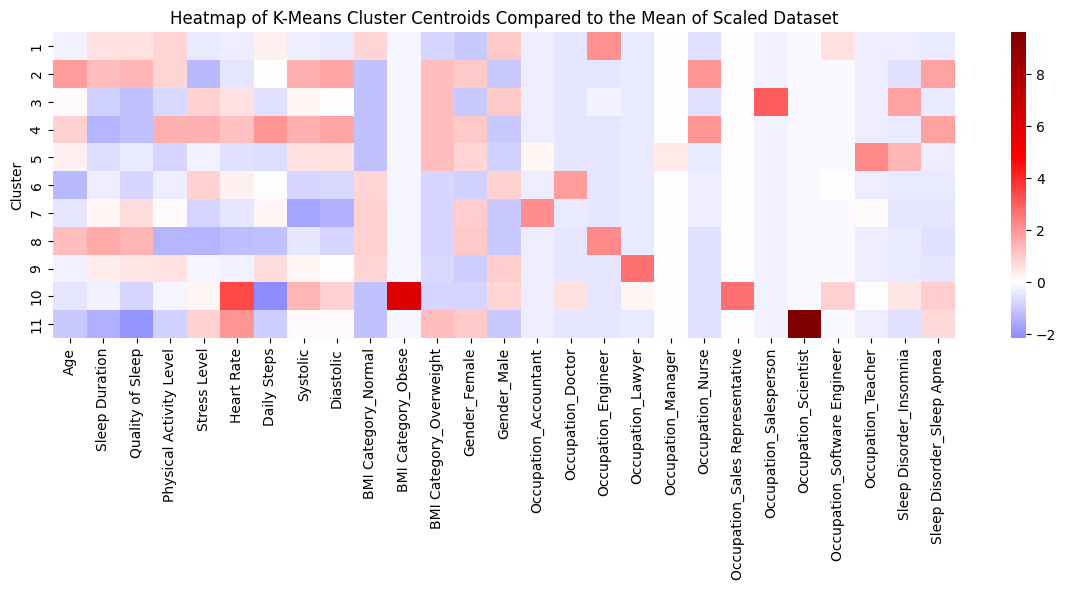

In [63]:

# The dataset needs to be converted to Pandas Dataframe first. Then execute Kmeans with 11 clusters
scaled_data_df_kmeans = pd.DataFrame(scaled_data, columns=cleaned_data.columns)
kmeans = KMeans(n_clusters=11, random_state=2025)
labels_kmeans = kmeans.fit_predict(scaled_data_df_kmeans)
scaled_data_df_kmeans['Cluster'] = labels_kmeans +1 # Add the labels to the dataset

cluster_means_scaled = scaled_data_df_kmeans.groupby('Cluster').mean()

plt.figure(figsize=(12, 6))
# center the scale around zero 
sns.heatmap(cluster_means_scaled,
            cmap='seismic',
            center=0)

plt.title('Heatmap of K-Means Cluster Centroids Compared to the Mean of Scaled Dataset')
plt.tight_layout()
plt.show()

#### Interpretation of the graph
The K-means model produces the largest number of clusters, which can be examined through the heatmap presented below. Notably, the data are segmented by gender, yet some overlap exists among clusters. For instance, Clusters 3 and 4 exhibit similar values in the continuous variables but differ in gender and occupation. This indicates that the dataset is not straightforwardly separable, a conclusion supported by the earlier silhouette analyses.

Individual profiles can also be derived for each cluster. For example, Cluster 10 primarily consists of obese individuals with notably high heart rates, lower sleep quality, and lower levels of physical activity; the group also appears to be relatively young and is predominantly composed of males working in sales. In contrast, Cluster 9 is largely characterized by normal- weight male lawyers, offering relatively limited information regarding health variables.

#### Visualizing DBSCAN


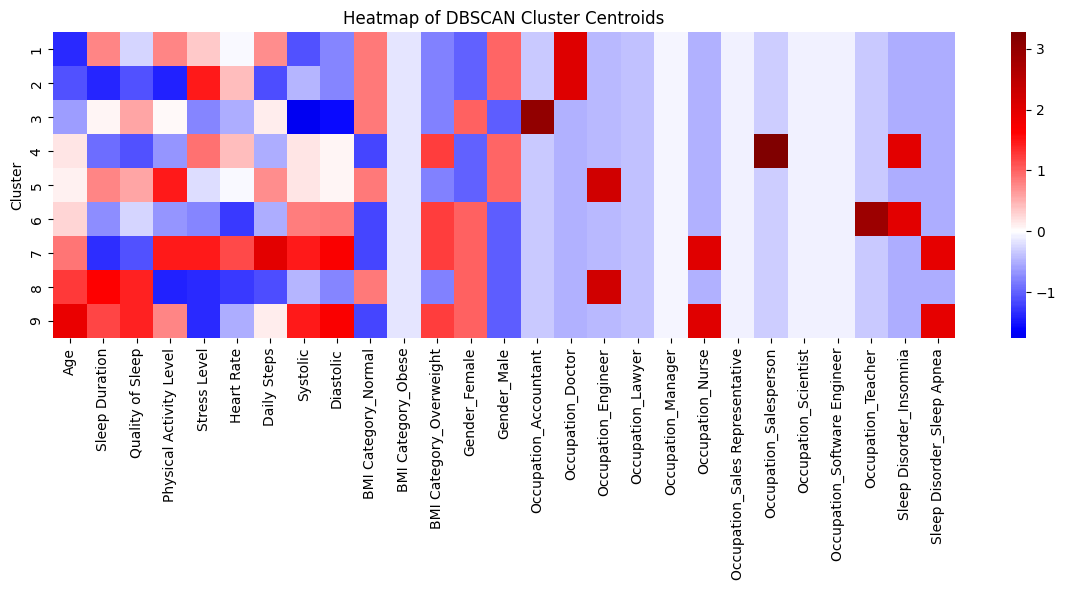

In [64]:
scaled_data_df_dbscan = pd.DataFrame(scaled_data, columns=cleaned_data.columns)
dbscan = DBSCAN(eps=0.15, min_samples=13)
labels_dbscan = dbscan.fit_predict(scaled_data_df_dbscan)
scaled_data_df_dbscan['Cluster'] = labels_dbscan +1
scaled_data_df_dbscan = scaled_data_df_dbscan[scaled_data_df_dbscan['Cluster'] != 0]  # remove the outliers

cluster_means_dbscan = scaled_data_df_dbscan.groupby('Cluster').mean()
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means_dbscan, cmap='seismic', center=0)
plt.title('Heatmap of DBSCAN Cluster Centroids')
plt.tight_layout()
plt.show()


#### Interpretation of the Heatmap
Since DBSCAN and K-means both rely on distance-based principles (albeit in distinct ways), their clustering outcomes show some similarities. However, the smaller number of clusters produced by DBSCAN influences how the data are partitioned. For instance, occupations such as Scientist, Software Engineer, Sales Representative, and Manager remain near zero in the heatmap, suggesting that these categories are not captured as dense regions. At the same time, DBSCAN does isolate certain professions into identifiable clusters, and there appears to be less overlap among clusters compared to K-means making, thus the heatmap "brighter".

In terms of cluster profiles, Cluster 7, for example, contains individuals with high blood pressure, overweight status, elevated stress levels, and higher physical activity—predominantly female nurses. Interestingly, none of the clusters exhibit elevated mean values for obesity. Based on this heatmap, it may be worthwhile to rerun the analysis without the categorical variables, thereby obtaining simpler models and focusing on continuous variables that appear to provide more information.

#### Visualizing PCA
This visualization is based on PCA loadings, which capture the contribution of each original variable to the principal components. Much like the heatmap, the loadings indicate the relationship between variables and the components: a positive loading means that an increase in the variable leads to higher values in that component, while a negative loading implies that an increase in the variable results in lower component scores. In essence, the sign and magnitude of the loadings reveal both the direction and strength of each variable’s influence on the corresponding principal component.

In [57]:
# Fit the PCA and extract the loadings
scaled_data_df_pca = pd.DataFrame(scaled_data, columns=cleaned_data.columns)

pca = PCA(n_components=9)
pca.fit(scaled_data_df_pca)

loadings = pd.DataFrame(pca.components_.T,
                        columns = [f'PC{i+1}' for i in range(9)],
                        index = scaled_data_df_pca.columns)

loadings.head(27)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Age,0.274095,0.258748,-0.059035,-0.158968,-0.047420,-0.175576,0.122175,-0.048426,-0.028378
Sleep Duration,-0.101149,0.364246,0.088903,-0.249978,0.045356,-0.075814,0.031271,-0.041192,0.033276
Quality of Sleep,-0.061754,0.420779,0.043722,-0.166992,-0.012583,0.053714,0.070907,-0.036837,0.029050
Physical Activity Level,0.119886,0.084200,0.427015,0.025088,-0.162367,0.154406,0.125199,-0.070633,0.036849
Stress Level,0.034584,-0.398969,0.116561,0.173453,-0.060213,-0.145706,-0.000953,-0.010906,-0.040499
Heart Rate,0.113448,-0.320238,0.165914,0.002292,0.297324,-0.043519,0.182352,0.068539,0.044775
Daily Steps,0.080036,0.039637,0.387800,0.220554,-0.330167,0.115684,0.036039,-0.051325,0.002660
Systolic,0.351996,-0.039658,0.067905,-0.268798,-0.004438,0.037345,-0.111732,0.039107,-0.027281
Diastolic,0.370500,-0.022705,0.109686,-0.182469,-0.041691,0.054801,-0.121714,0.005319,0.006580
BMI Category_Normal,-0.357759,0.113462,0.158097,0.067969,0.018672,-0.024624,-0.058316,0.012408,-0.041842


#### Interpretation of the Loadings
Principal Component Analysis (PCA) ranks components in order of importance, with the first component explaining the most variance and each subsequent component explaining progressively less. In practice, loadings with an absolute value greater than about 0.3 can be considered influential, though this threshold may vary depending on context. Consequently, the less influential components often have many values close to zero, capturing more subtle or “outlier-like” aspects of the data.

From these results we can see that PC1 highlights individuals who are generally older (Age > 0.25), have higher blood pressure, are overweight females, and work as nurses with sleep apnea. PC2 contrasts with PC1 by indicating higher sleep health and lower stress and heart rate—suggesting a healthier, more balanced profile. PC9, on the other hand, has many near-zero loadings but a distinctly high loading for Software Engineer, implying a more narrowly defined subgroup.

It is also noteworthy that each principal component includes opposing gender loadings, indicating that PCA naturally distinguishes data by gender as well.



### Conclusion

Overall, K-Means, DBSCAN, and PCA yielded similar high-level insights, suggesting that the dataset itself was not strongly separable. In each clustering approach, there was no sharp “elbow” or clear maximum in the silhouette scores, and PCA did not reveal highly distinct groupings. Consequently, the methods consistently indicated that the data does not naturally split into well-defined clusters.